In [3]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms

import random
import numpy as np

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# Data

In [4]:
transform = transforms.ToTensor()

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 197kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.36MB/s]


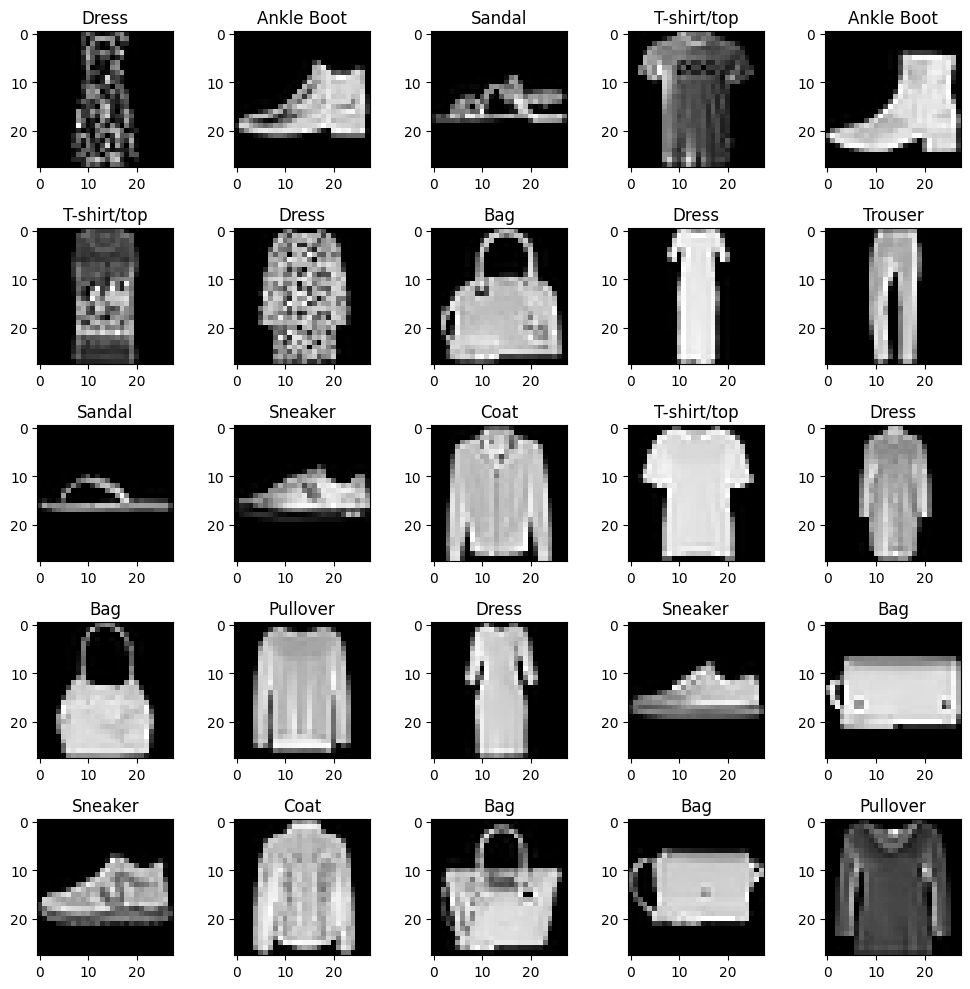

In [5]:
batch = next(iter(training_loader))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(*batch)):
    if i > 24:
        break
    plt.subplot(5, 5, i + 1)
    plt.imshow(image[0], cmap="gray")
    plt.title(classes[label])

plt.tight_layout()

# Exercise

You are required to train an MLP on the Fashion MNIST dataset. For this task, you must define the following:

* The objective function
* The model architecture
* The optimizer
* The training loop

You will train three MLP models, each with different hyperparameters. You must vary at least two of the following aspects between the models:

* Number of layers
* Number of neurons
* Activation function
* Optimizer


## Deliverables
* The complete code
* Learning curves for the three MLP models
* Table summarizing the changes in the hyperparameters and the performance of the models on the train and test sets.
* A write-up analyzing how your choices impacted the results.

## **Model Architecture**

In [6]:
class SimpleCNN(nn.Module):

  def __init__(self, n_class, n_layers, hidden_units, activation) -> None:

     super().__init__()

     self.n_class = n_class
     self.n_layers = n_layers
     self.hidden_units = hidden_units
     self.activation_type = activation               # Store activation type
     self.flattened_size = 64 * 7 * 7                # (After 3 pooling layers on 28x28 input)


     self.flatten = nn.Flatten(start_dim=1)          # Define the flattening layer
     self.pool = nn.MaxPool2d(2, 2)                  # Max pooling
     self.dropout = nn.Dropout(p=0.5)                # Dropout


     # Define the Feature Extraction Layers
     self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1, padding='same')
     self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding='same')


     # Define the Classification Layers
     self.hidden_layers = nn.ModuleList([nn.Linear(self.hidden_units, self.hidden_units) if layer != 0 else nn.Linear(self.flattened_size, self.hidden_units) for layer in range(n_layers)])
     self.output_layer = nn.Linear(self.hidden_units, n_class)


     if self.activation_type == 'relu':
        self.activation = nn.ReLU()
     elif self.activation_type == 'leakyRelu':
        self.activation = nn.LeakyReLU()
     elif self.activation_type == 'tanh':
        self.activation = nn.Tanh()
     elif self.activation_type == 'sigmoid':
        self.activation = nn.Sigmoid()
     else:
        raise ValueError("Invalid activation function. Choose from ['relu', 'leakyRelu', 'tanh', 'sigmoid'].")



  def forward(self, x):

    #print('ORIGINAL X_shapeeeeeee:', x.shape)

    x = self.pool(self.activation(self.conv1(x)))
    #print('First Pool X_shapeeeeeee:', x.shape)
    x = self.pool(self.activation(self.conv2(x)))
    #print('Second Pool X_shapeeeeeee:', x.shape)

    x = self.flatten(x)            # Reshape from (batch, n_channels, 28, 28) -> (batch, 784)
    #print('Flattened X_shapeeeeeee:', x.shape)

    for idx, layer in enumerate(self.hidden_layers):
        x = layer(x)            # Pass the input to the neural network
        x = self.activation(x)      # Apply some non-linearity
        #x = self.dropout(x)         # Apply dropout
        #print(f'Layer {idx+1}:', x.shape)

    output = self.output_layer(x)
    #print('OUTPUT LAYER X_shapeeeeeee:', x.shape)

    return output

## **Define the Device**

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Objective Function**

In [8]:
criterion = nn.CrossEntropyLoss()           # Since we are dealing with a multi-class classification problem, we will choose cross entropy

## **Training Function**

In [9]:
def train_model(model, criterion, device, train_dataloader, lr, n_epochs):

  model.to(device)      # Move model to device
  model.train()         # Set the model to training phase

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)  # Define the optimizer
  epoch_losses = []


  # Train the model for a number of epochs
  for epoch in range(n_epochs):

    # Reset the epoch loss at the beginning of each epoch
    epoch_loss = 0.0
    total_samples = 0

    # Iterate through each batch of data and perform forward & backward pass
    for images, labels in train_dataloader:

      images, labels = images.to(device), labels.to(device)       # Move images and labels to device
      #print('Images SHAPEEE:', images.shape)
      #print('Labels SHAPEEE:', labels.shape)

      # Forward Pass
      output = model(images)
      loss = criterion(output, labels)      # Compute loss

      batch_size = labels.size(0)                   # Get size of current batch
      total_samples += batch_size                   # Accumulate number of samples used in each epoch
      epoch_loss += loss.item() * batch_size        # Accumulate loss for each epoch


      # Backward pass
      loss.backward()         # Perform backpropagation
      optimizer.step()        # Update the weights (model parameters)
      optimizer.zero_grad()   # Zero the gradients to avoid accumulation between batches of data

    epoch_losses.append(epoch_loss/ total_samples)       # Store the average training loss for the recently finished epoch
    print(f'Epoch {epoch+1}/{n_epochs} finished with loss of {epoch_loss / total_samples}')


  return epoch_losses

## **Validation Function**

In [10]:
def evaluate_model(model, criterion, device, val_loader):

  model.to(device)    # Move Model to Device
  model.eval()        # Set the model to the evaluation mode
  val_loss = 0.0      # Initialize the validation losss
  correct, total = 0, 0

  # No gradient tracking (prevents backtracking)
  with torch.no_grad():

    for images, labels in val_loader:

      images, labels = images.to(device), labels.to(device)
      output = model(images)

      # Get size of current batch
      batch_size = labels.size(0)

      # Compute loss
      loss = criterion(output, labels)
      val_loss += loss.item()

      # Compute the accuracy
      _, predicted = torch.max(output, 1)             # Get class with highest probability
      correct += (predicted == labels).sum().item()
      total += batch_size

  val_loss /= total        # Average the validation loss
  val_accuracy = 100 * (correct / total)      # Get validation accuracy

  print('Validation Loss:', val_loss)
  print(f'Validation Accuracy: {val_accuracy} %')

  return val_loss, val_accuracy

## **Loss Plotting Function**

In [11]:
def plot_loss(train_losses):

  n_epochs = len(train_losses)

  plt.figure(figsize=(6, 4))
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.plot(range(1, n_epochs + 1), train_losses, marker='o', linestyle='-', color='b', label='Training Loss')

  plt.title('Training Loss Across Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Training Loss')

  plt.xticks(range(1, n_epochs + 1, max(1, n_epochs // 10)))

  plt.legend()
  plt.show()

## **Some Useful Variables**

In [12]:
n_classes = len(classes)
batch = next(iter(training_loader))         # Select a random batch
images, labels = batch[0], batch[1]
image_shape = torch.prod(torch.tensor(images[0].size())).item()
print('Shape of each Flattened Image is:', image_shape)

Shape of each Flattened Image is: 784


## **First Model**

In [41]:
model_1 = SimpleCNN(n_class=n_classes, n_layers=2, hidden_units=5, activation='relu')
epoch_losses = train_model(model_1, criterion, device, train_dataloader=training_loader, lr=0.001, n_epochs=200)

Epoch 1/200 finished with loss of 1.4255262474060058
Epoch 2/200 finished with loss of 0.7501115340868632
Epoch 3/200 finished with loss of 0.6269280909697215
Epoch 4/200 finished with loss of 0.5800149713277817
Epoch 5/200 finished with loss of 0.5440374770561854
Epoch 6/200 finished with loss of 0.520477753798167
Epoch 7/200 finished with loss of 0.5005393978357315
Epoch 8/200 finished with loss of 0.4868948340177536
Epoch 9/200 finished with loss of 0.4805731420040131
Epoch 10/200 finished with loss of 0.4677470007499059
Epoch 11/200 finished with loss of 0.4634093409697215
Epoch 12/200 finished with loss of 0.45646641203165056
Epoch 13/200 finished with loss of 0.45110096821784973
Epoch 14/200 finished with loss of 0.44899519232114155
Epoch 15/200 finished with loss of 0.4454942130088806
Epoch 16/200 finished with loss of 0.44398704148133594
Epoch 17/200 finished with loss of 0.4415276749253273
Epoch 18/200 finished with loss of 0.44277442469994227
Epoch 19/200 finished with loss o

Validation Loss: 0.0037556347459554674
Validation Accuracy: 83.54 %


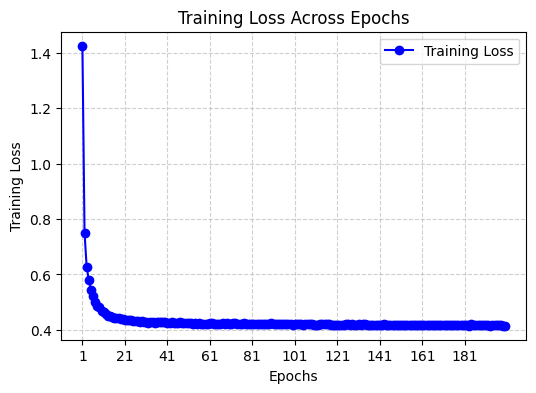

In [42]:
val_loss, val_acc = evaluate_model(model_1, criterion, device, validation_loader)
plot_loss(epoch_losses)

### **2- Second Hyperparameters Combination**

In [21]:
model_2 = SimpleCNN(n_class=n_classes, n_layers=2, hidden_units=10, activation='relu')
epoch_losses = train_model(model_2, criterion, device, train_dataloader=training_loader, lr=0.01, n_epochs=50)

Epoch 1/50 finished with loss of 0.7821239758968354
Epoch 2/50 finished with loss of 0.6275391417900721
Epoch 3/50 finished with loss of 0.6044256296316782
Epoch 4/50 finished with loss of 0.586185693303744
Epoch 5/50 finished with loss of 0.5785295286814371
Epoch 6/50 finished with loss of 0.5670247476498286
Epoch 7/50 finished with loss of 0.564430050253868
Epoch 8/50 finished with loss of 0.5621781642198562
Epoch 9/50 finished with loss of 0.5651670090198517
Epoch 10/50 finished with loss of 0.5622150453726451
Epoch 11/50 finished with loss of 0.5624063755830129
Epoch 12/50 finished with loss of 0.5612249904235204
Epoch 13/50 finished with loss of 0.5631515357176463
Epoch 14/50 finished with loss of 0.5608826701482137
Epoch 15/50 finished with loss of 0.564200520046552
Epoch 16/50 finished with loss of 0.5612623229503632
Epoch 17/50 finished with loss of 0.5618451004266739
Epoch 18/50 finished with loss of 0.5600298280318579
Epoch 19/50 finished with loss of 0.5571996918280919
Epoch

Validation Loss: 0.004325804275274276
Validation Accuracy: 80.84 %


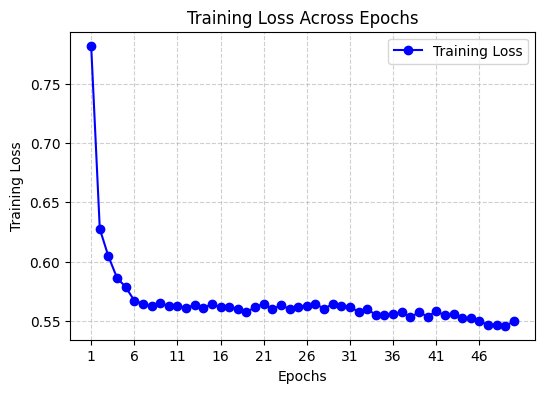

In [22]:
val_loss, val_acc = evaluate_model(model_2, criterion, device, validation_loader)
plot_loss(epoch_losses)